<a href="https://colab.research.google.com/github/rhaagsma/Projeto_Final_Marvel/blob/insight-1/InsightsPre%C3%A7osComics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insights sobre preços dos quadrinhos:
Existem muitos preços faltantes
* Total de quadrinhos: 64273
* Quantidade de quadrinhos com preço 0: 24819

Ou seja, aproximadamente 38.62% dos quadrinhos estão sem preço

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
con = sqlite3.connect('banco.db')
# Carregar dados da tabela comics
df = pd.read_sql_query("SELECT price, year FROM comics", con)
con.close()

# Estatísticas básicas
media = df['price'].mean()
mediana = df['price'].median()
minimo = df['price'].min()
maximo = df['price'].max()

print(f"Comics Totais: {df.shape[0]}")
print(f"Média: {media:.2f}")
print(f"Mínimo: {minimo:.2f}")
print(f"Máximo: {maximo:.2f}\n")

Comics Totais: 64272
Média: 6.14
Mínimo: 0.00
Máximo: 500.00



## Faremos a filtragem dos dados para analisar somente os quadrinhos com preço disponível

In [ ]:
# Filtrar apenas os preços > 0
df = df[(df['price'] > 0)]

# Estatísticas básicas
media = df['price'].mean()
mediana = df['price'].median()
minimo = df['price'].min()
maximo = df['price'].max()

print(f"Comics com preço diferente de 0: {df.shape[0]}")
print(f"Média: {media:.2f}")
print(f"Mínimo: {minimo:.2f}")
print(f"Máximo: {maximo:.2f}")

Comics com preço diferente de 0: 39459
Média: 10.00
Mínimo: 0.10
Máximo: 500.00


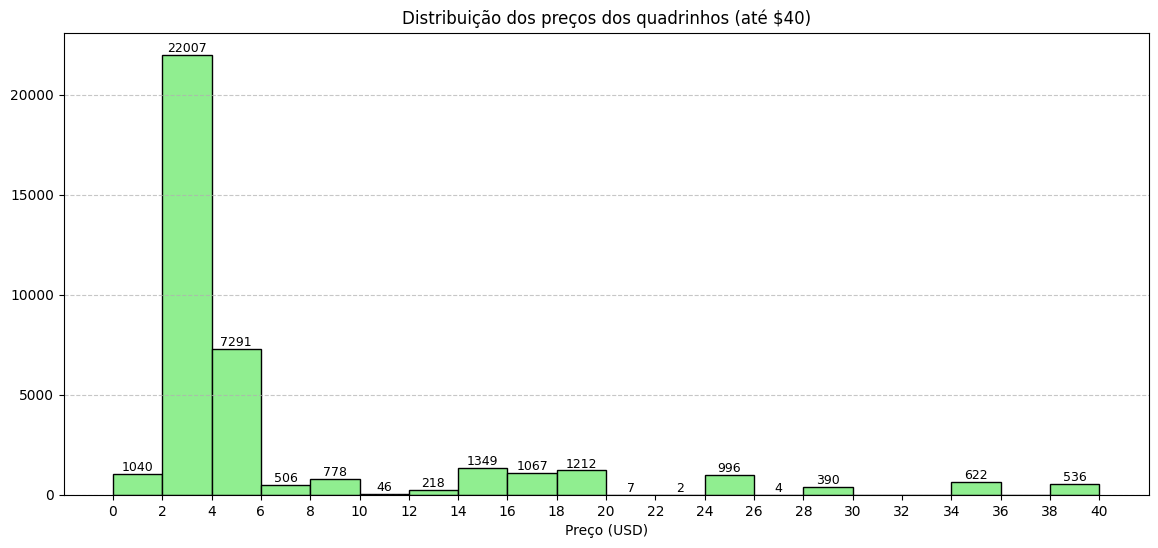

In [78]:
plt.figure(figsize=(14, 6))
counts, bins, bars = plt.hist(df['price'], bins=range(0, 41, 2), edgecolor='black', color='lightgreen')
plt.title("Distribuição dos preços dos quadrinhos (até $40)")
plt.xlabel("Preço (USD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 41, 2))

# Adicionar os valores acima de cada barra
for bar, count in zip(bars, counts):
    if count > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            count + 0.5,
            str(int(count)),
            ha='center', va='bottom', fontsize=9
        )

plt.show()


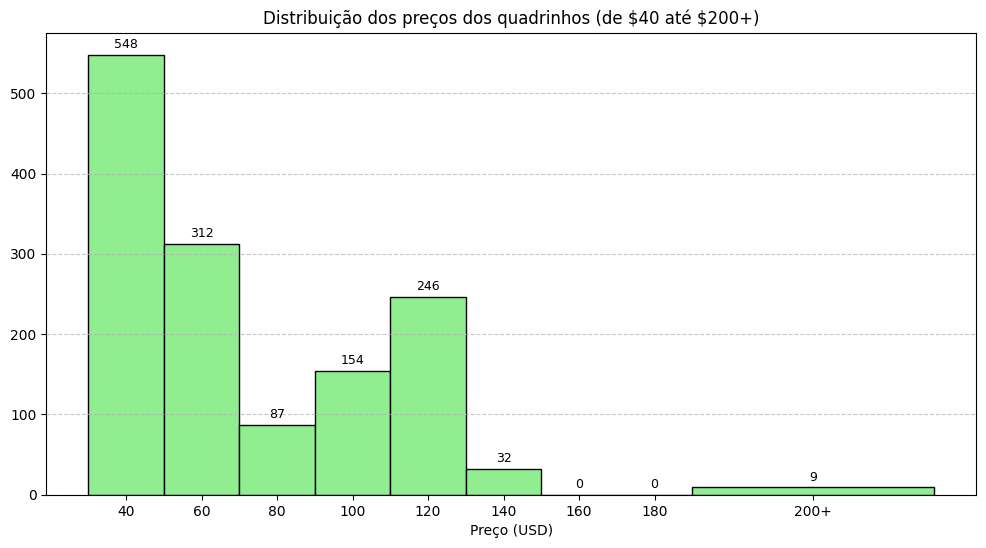

In [67]:
# Definir os bins de 40 até 200 (de 20 em 20), e um bin final para preços > 200
bins = list(range(40, 201, 20)) + [df['price'].max() + 20]
counts, edges = np.histogram(df['price'], bins=bins)

widths = []
for i in range(len(edges) - 1):
    if edges[i] == 200:
        # Aumentar em 15% a largura da última barra
        largura = (edges[i+1] - edges[i]) * 0.20
    else:
        largura = edges[i+1] - edges[i]
    widths.append(largura)

# Posições no eixo X (alinhadas pela esquerda)
x_pos = [edges[i] for i in range(len(edges) - 1)]

# Plotar gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(x_pos, counts, width=widths, align='edge', edgecolor='black', color='lightgreen')

plt.title("Distribuição dos preços dos quadrinhos (de \$40 até \$200+)")
plt.xlabel("Preço (USD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

def calcular_centros_customizados(bins, limite=200, centro_personalizado=232):
    centros = []
    for i in range(len(bins) - 1):
        if bins[i] >= limite:
            centros.append(centro_personalizado)
        else:
            centros.append((bins[i] + bins[i+1]) / 2)
    return centros

centros = calcular_centros_customizados(bins)
plt.xticks(centros, [f'{bins[i]}+' if bins[i] >= 200 else f'{bins[i]}' for i in range(len(bins) - 1)])

# Mostrar os valores acima de cada barra
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Posição X centralizada na barra
        height + 5,                         # Um pouco acima da barra
        str(height),                        # O valor da frequência
        ha='center', va='bottom', fontsize=9
    )


plt.show()

## Ocorrências dos preços 200 e 500

In [ ]:
df_temp = df[(df['price'] >= 500)]
print(f"Quantidade de preços iguais à $500: {df_temp.shape[0]}")
df_temp = df[(df['price'] >= 200) & (df['price'] < 220)]
print(f"Quantidade de preços iguais à $200: {df_temp.shape[0]}")

Quantidade de preços iguais à $500: 2
Quantidade de preços iguais à $200: 7


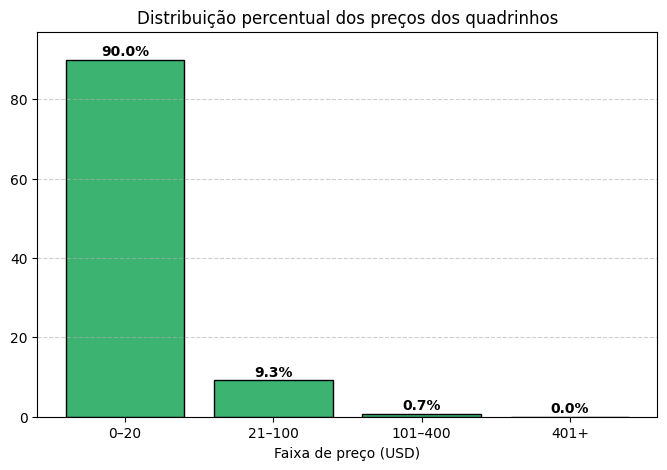

In [ ]:
# Criar as faixas de preço
bins = [0, 20, 100, 400, float('inf')]
labels = ['0–20', '21–100', '101–400', '401+']

# Criar nova coluna com a faixa de preço correspondente
df['faixa_preco'] = pd.cut(df['price'], bins=bins, labels=labels, right=True)

# Contar a quantidade de quadrinhos por faixa
contagem = df['faixa_preco'].value_counts().sort_index()

# Calcular porcentagens
porcentagens = (contagem / contagem.sum()) * 100


plt.figure(figsize=(8, 5))
plt.bar(porcentagens.index, porcentagens.values, color='mediumseagreen', edgecolor='black')
plt.title("Distribuição percentual dos preços dos quadrinhos")
plt.xlabel("Faixa de preço (USD)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, porcentagens.max() + 7)


# Mostrar os valores percentuais acima das barras
for i, v in enumerate(porcentagens.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()

## Ano de lançamento
Extraímos a data presente no título dos quadrinhos para termos o dado do ano de lançamento

Alguns quadrinhos não possuíam o ano no título, por isso, para essa análise filtramos os dados somente pelos quadrinhos com o ano de lançamento presente no título

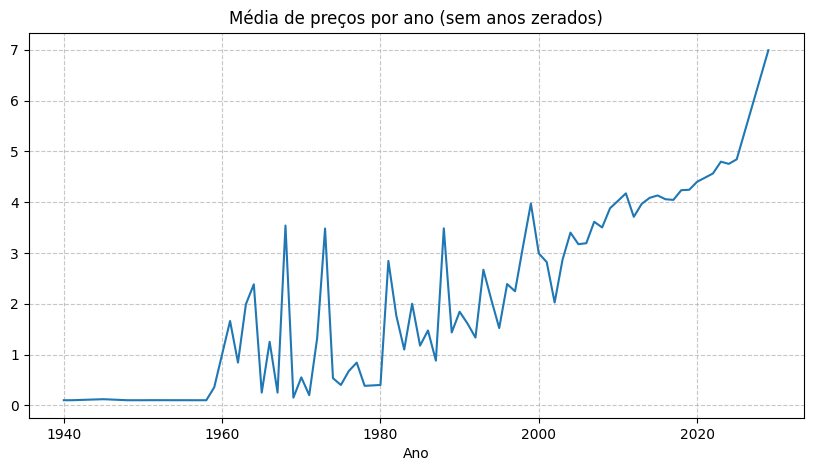

In [ ]:
# Filtrar apenas os anos diferentes de 0 e preços > 0
df_validos = df[(df['year'] != 0) & (df['price'] > 0)]

df_validos.groupby('year')['price'].mean().plot(kind='line', figsize=(10, 5))
plt.title("Média de preços por ano (sem anos zerados)")
plt.xlabel("Ano")
plt.grid(linestyle='--', alpha=0.7)
plt.show()
